In [1]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
from astropy.io import fits
from scipy.stats import linregress
import cmcrameri.cm as cmc 

In [2]:
# defining path to the pipeline

path = '/Users/eleanorgallay/SULIcmb/pipe/'

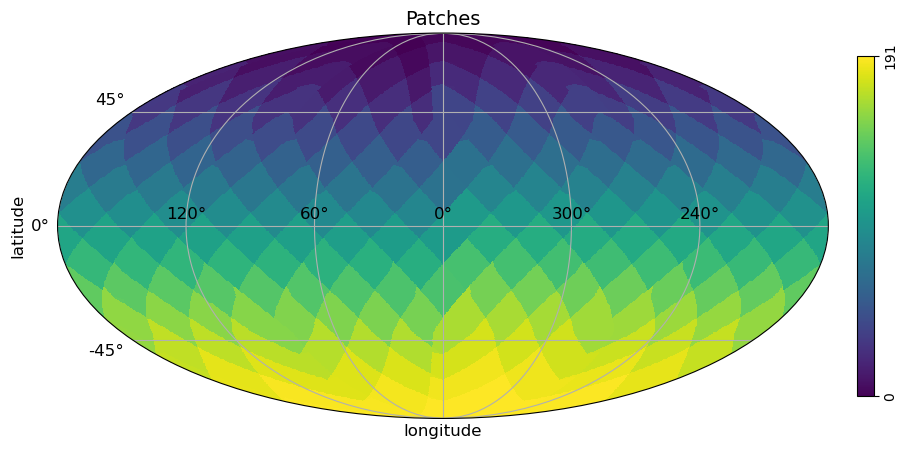

In [18]:
# reading in akari wide-s and iras data, noth maps in ecliptic coordinates

akari = hp.read_map('/Users/eleanorgallay/SULIcmb/pipe/ecl_akari_s_filled.fits')
iras = hp.read_map('/Users/eleanorgallay/SULIcmb/pipe/ecl_iras.fits')

# file from Elisa that has the coordinates to the healpix faces
hdul_faces = fits.open(path + "pixfaces_nside=2048_subdivide=4_borderpix=128.fits")
faces = hdul_faces[0].data

# show the link between the faces and their position on the full sky
mask_test = np.ones(hp.nside2npix(2048))
for i in range(len(faces)):
    mask_test[faces[i]] = i

hp.projview(
    mask_test,
    coord=["G"],
    graticule=True,
    graticule_labels=True,
    xlabel="longitude",
    ylabel="latitude",
    cb_orientation="vertical",
    latitude_grid_spacing=45,
    projection_type="mollweide",
    title="Patches",
);
hp.graticule()
plt.show()

# COSINE SQUARED MASK


# Define size
size = 768
border = 256

# 1D cosine squared
x = np.linspace(0, 1, border)
cos = np.cos(np.pi * x / 2) ** 2  # 1 → 0

# 1D mask for one axis
mask_1d = np.ones(size)
mask_1d[:border] = cos[::-1]   # Top/left edge
mask_1d[-border:] = cos       # Bottom/right edge

# 2D mask 
mask_2d = np.outer(mask_1d, mask_1d)



# K SQUARES 


size = 768
freq = np.fft.fftfreq(n = size)
freq_shifted = np.fft.fftshift(freq) 

# Create 2D grid of k values
kx, ky = np.meshgrid(freq_shifted, freq_shifted, indexing='ij')

# Compute squared k values
k_squared = kx**2 + ky**2

In [4]:
def fft(rot):
    pixel = hp.ang2pix(nside = 2048, theta=rot[0], phi=rot[1], lonlat=True)
    n = int(mask_test[pixel])
    akari_test = akari[faces[n]]
    iras_test = iras[faces[n]]

    # Face at rot
    plt.imshow(akari_test, cmap = cmc.batlow) 
    plt.title(f'AKARI patch at {rot}')
    plt.colorbar()
    plt.show()

    # Face at rot
    plt.imshow(iras_test, cmap = cmc.batlow) 
    plt.title(f'IRAS patch at {rot}')
    plt.colorbar()
    plt.show()

    # applying the cosine squared mask
    cos_akari_test = akari_test * mask_2d
    cos_iras_test = iras_test * mask_2d 

    # AKARI FFT
    fft = np.fft.fft2(cos_akari_test)
    fft_shifted = np.fft.fftshift(fft)
    abs_fft = np.abs(fft_shifted)

    # IRAS FFT
    iras_fft = np.fft.fft2(cos_iras_test)
    iras_fft_shifted = np.fft.fftshift(iras_fft)
    iras_abs_fft = np.abs(iras_fft_shifted)


    # PHASE 

    akari_phase = np.angle(fft_shifted)
    iras_phase = np.angle(iras_fft_shifted)

    # PLOTTING
    
    plt.figure(figsize=(6, 5))
    plt.imshow(abs_fft, cmap='gray', vmin = 0, vmax = 1e2)
    plt.title(f'AKARI FFT magnitude at {rot} ')
    plt.colorbar()
    plt.show()

    plt.figure(figsize=(6, 5))
    plt.imshow(iras_abs_fft, cmap='gray', vmin = 0, vmax = 1e2)
    plt.title(f'IRAS FFT magnitude at {rot} ')
    plt.colorbar()
    plt.show()

    return akari_test, iras_test, abs_fft, iras_abs_fft, akari_phase, iras_phase

In [5]:
def fill(stripes, mask, centerlimit, akari_abs_fft, iras_abs_fft, akari_phase):
    fade_width = 0.001
    
    centermask = np.zeros_like(k_squared)
    
    center = k_squared < centerlimit
    fade = (k_squared >= (centerlimit)) & (k_squared < (centerlimit + fade_width))
    centermask[center] = 1
    centermask[fade] = 0.5 * (1 + np.cos(np.pi * (k_squared[fade] - (centerlimit - fade_width / 2)) / fade_width))

    akari_center = stripes * centermask

    akari_edge = stripes * (1 - centermask)
    
    plt.imshow((akari_center)*1e-6, cmap='gray', vmax = 0.00005)
    plt.title("mask for computing linear regression (center)")
    plt.show()

    plt.imshow((akari_edge)*1e-6, cmap='gray', vmax = 0.00005)
    plt.title("mask for computing linear regression (edge)")
    plt.show()


    valid_akari_center = akari_abs_fft[(centermask == 1) & (mask == 0)]
    valid_iras_center = iras_abs_fft[(centermask == 1) & (mask == 0)]

    valid_akari_edge = akari_abs_fft[(centermask == 0) & (mask == 0)]
    valid_iras_edge = iras_abs_fft[(centermask == 0) & (mask == 0)]

    # LINEAR REGRESSION 

    stats_center = linregress(valid_iras_center, valid_akari_center)
    slope_center = stats_center.slope
    intercept_center = stats_center.intercept

    stats_edge = linregress(valid_iras_edge, valid_akari_edge)
    slope_edge = stats_edge.slope
    intercept_edge = stats_edge.intercept

    tiny_k_mask = np.zeros_like(k_squared)

    tiny_k_fade = k_squared < fade_width
    tiny_k_mask[tiny_k_fade] = 0.5 * (1 + np.cos(np.pi * k_squared[tiny_k_fade] / fade_width))

    # FILLING

    fill_iras_center = iras_abs_fft * slope_center + intercept_center
    fillcentermask = 1 - (centermask * mask * (1 - tiny_k_mask))
    filled_center = fillcentermask * akari_abs_fft + (1 - fillcentermask) * fill_iras_center

    fill_iras_edge = iras_abs_fft * slope_edge + intercept_edge
    filledgemask = 1 - (1 - centermask) * (mask)
    filled = filledgemask * filled_center + (1 - filledgemask) * fill_iras_edge

    # PLOTTING 

    plt.figure(figsize=(6, 5))
    plt.imshow(akari_abs_fft*1e-6, cmap='gray', vmax = 0.0001)
    plt.title(f'AKARI FFT magnitude at {rot} ')
    plt.colorbar()
    plt.show()

    plt.figure(figsize=(6, 5))
    plt.imshow((np.abs(filled))*1e-6, cmap='gray', vmax = 0.0001)
    plt.title(f'Filled AKARI FFT magnitude at {rot} ')
    plt.colorbar()
    plt.show()

    # PRINTING STATS 

    print(f"slope (center): {slope_center}")
    print(f"intercept (center): {intercept_center}")
    print(f"slope (edge): {slope_edge}")
    print(f"intercept (edge): {intercept_edge}")


    # INVERSE FFT 

    filled_abs = filled * np.exp(1j * akari_phase)
    
    fft_unshifted = np.fft.ifftshift(filled_abs)
    pixels_again = np.fft.ifft2(fft_unshifted)

    # PLOTTING

    plt.imshow(iras_patch * mask_2d, cmap = cmc.batlow)
    plt.title('original iras')
    plt.colorbar()
    plt.show()

    plt.imshow(akari_patch * mask_2d, cmap = cmc.batlow)
    plt.title('original akari')
    plt.colorbar()
    plt.show()
    
    plt.imshow(np.abs(pixels_again), cmap = cmc.batlow)
    plt.title('filled abs value')
    plt.colorbar()
    plt.show()

    plt.imshow(akari_patch * mask_2d - pixels_again.real, vmin = -1e-1, vmax=1e-1, cmap = "coolwarm")
    plt.title('difference in filling')
    plt.colorbar()
    plt.show()

    plt.imshow(fillcentermask)
    plt.title("center filling")
    plt.colorbar()
    plt.show()

    plt.imshow(filledgemask)
    plt.title("edge filling")
    plt.colorbar()
    plt.show()

    return pixels_again

#### Patch at [-10, 10]

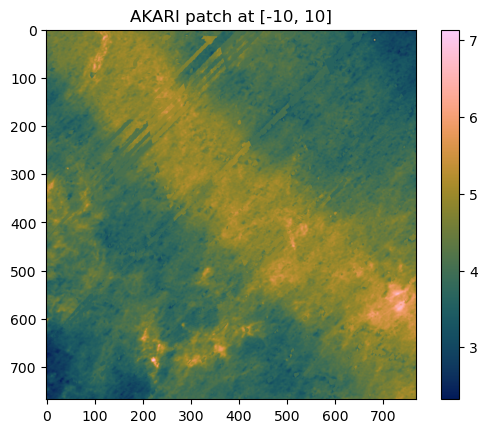

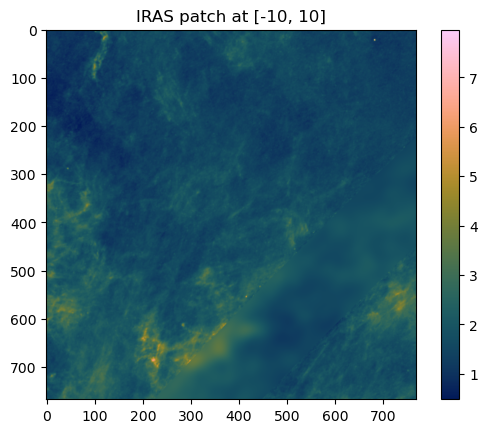

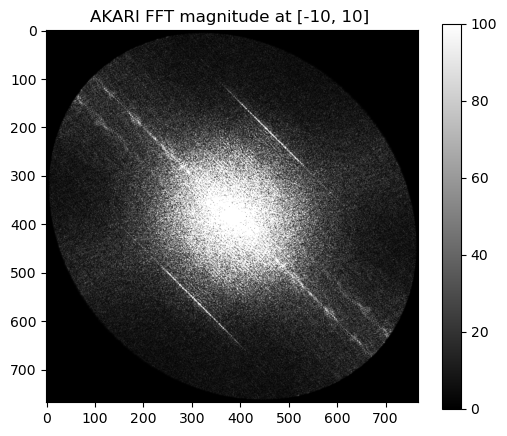

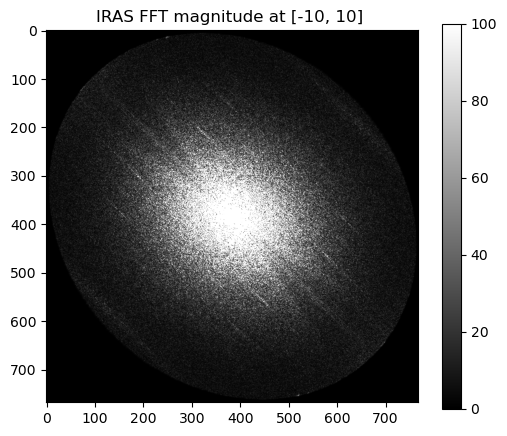

In [6]:
rot = [-10, 10]
akari_patch, iras_patch, akari_abs_fft, iras_abs_fft, akari_phase, iras_phase = fft(rot=rot)

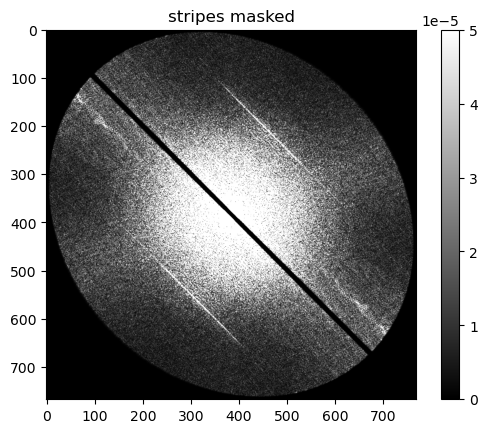

In [7]:
angles = [135]
width = 0.01
core_width = width/2
fade_width = width/2

mask = np.zeros_like(akari_abs_fft)

for angle in angles:
    theta = np.radians(angle)
    # Direction vector
    dx = np.cos(theta)
    dy = np.sin(theta)

    # Distance of each point from the stripe line (through center)
    distance = np.abs(kx * dx + ky * dy)

    # Build apodization mask using cosine taper
    stripe = distance <= (width / 2)
    fade = (distance > (width / 2)) & (distance < (width))
    

    mask[stripe] = 1
    mask[fade] = 0.5 * (1 + np.cos(np.pi * (distance[fade] - core_width) / fade_width))

stripes = akari_abs_fft * (1 - mask)
    
plt.imshow((stripes)*1e-6, cmap='gray', vmax = 0.00005)
plt.title("stripes masked")
plt.colorbar()
plt.show()

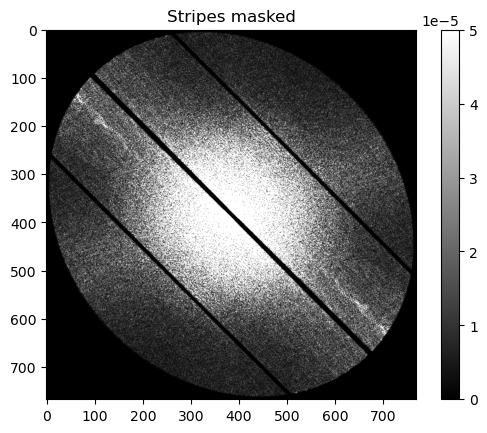

In [8]:
angle = 135
theta = np.radians(angle)
dx = np.cos(theta)
dy = np.sin(theta)
width = 0.007
core_width = width/2
fade_width = width/2
extrastripesmask = np.zeros_like(akari_abs_fft)
offset = 0.33

# Calculate position relative to offset center
kx_plus_offset = kx + offset

kx_minus_offset = kx - offset

# Distance to line through (kx0, ky0) with direction (dx, dy)
distance_plus = np.abs(kx_plus_offset * dx + ky * dy)
distance_minus = np.abs(kx_minus_offset * dx + ky * dy)


# Apodization mask
stripe_plus = distance_plus < (core_width)
fade_plus = (distance_plus > (core_width)) & (distance_plus < (width))

extrastripesmask[stripe_plus] = 1
extrastripesmask[fade_plus] = 0.5 * (1 + np.cos(np.pi * (distance_plus[fade_plus] - core_width) / fade_width))

stripe_minus = distance_minus < (core_width)
fade_minus = (distance_minus > (core_width)) & (distance_minus < (width))

extrastripesmask[stripe_minus] = 1
extrastripesmask[fade_minus] = 0.5 * (1 + np.cos(np.pi * (distance_minus[fade_minus] - core_width) / fade_width))

extrastripes = stripes * (1 - extrastripesmask)

mask2 = mask + extrastripesmask

plt.imshow((extrastripes)*1e-6, cmap='gray', vmax = 0.00005)
plt.title("Stripes masked")
plt.colorbar()
plt.show()


# plt.imshow(mask, cmap='gray', vmax = 0.00005)
# plt.title("stripe mask")
# plt.colorbar()
# plt.show()


# plt.imshow(extrastripesmask, cmap='gray', vmax = 0.00005)
# plt.title(" extra stripe mask")
# plt.colorbar()
# plt.show()


In [9]:
akari_phase_masked = akari_phase * (1 - mask)
iras_phase_masked = iras_phase * (1 - mask)

phase_correlation = np.corrcoef(akari_phase_masked, iras_phase_masked)

Text(0.5, 1.0, 'Correlation between AKARI and IRAS phases')

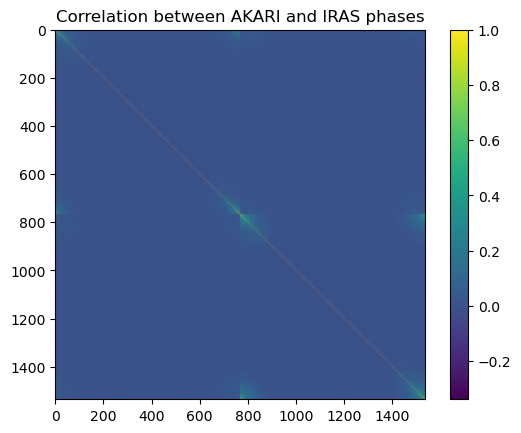

In [10]:
plt.imshow(phase_correlation)
plt.colorbar()
plt.title("Correlation between AKARI and IRAS phases")

In [11]:
# plt.hist(phase_correlation, bins = 50, range=[-0.2, 0.2])
# plt.title("Histogram of phase correlation coefficients")
# plt.show()

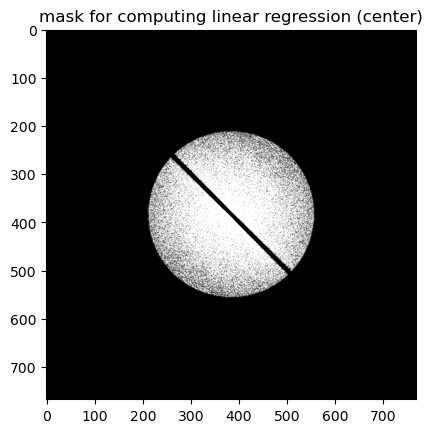

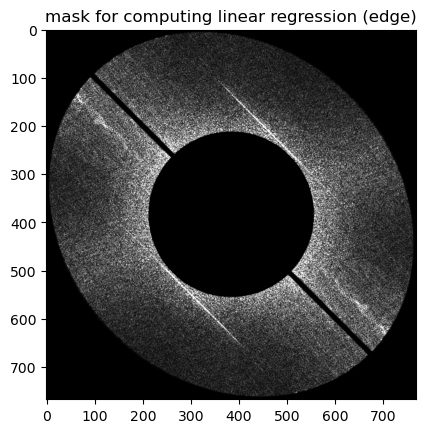

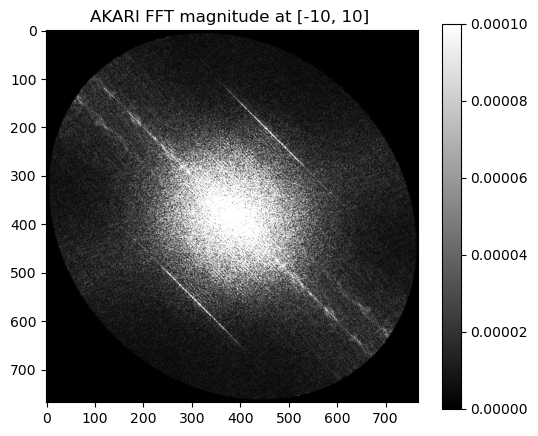

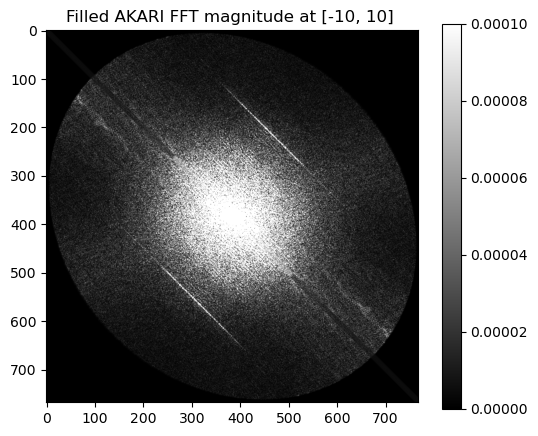

slope (center): 0.6768357965716693
intercept (center): 31.689932334076175
slope (edge): 0.6429691535107878
intercept (edge): 4.758716701242534


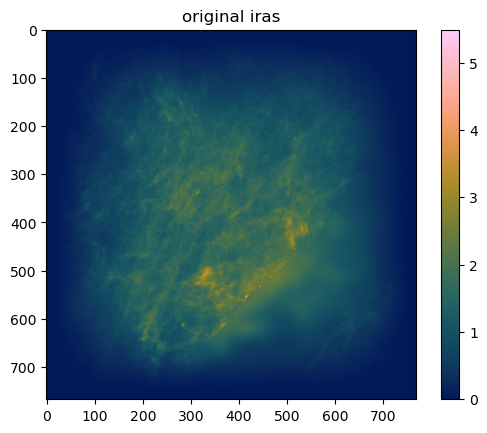

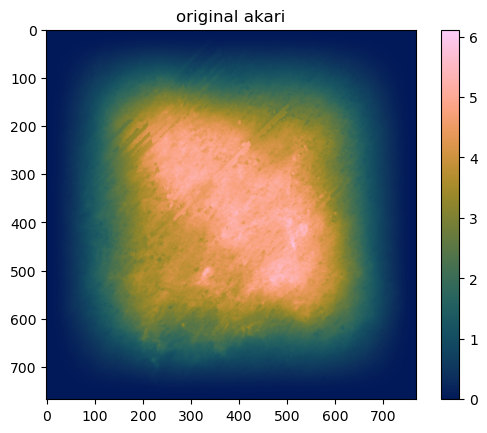

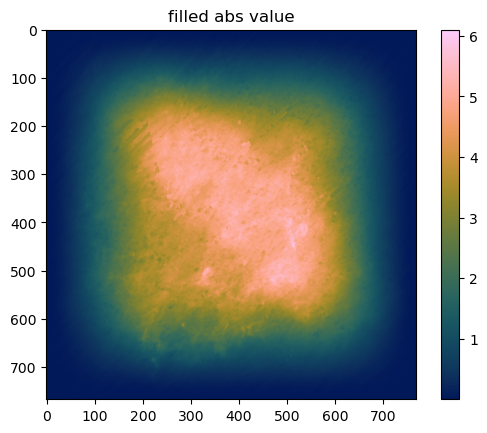

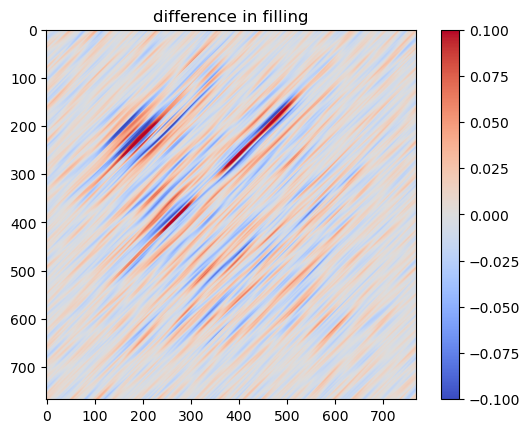

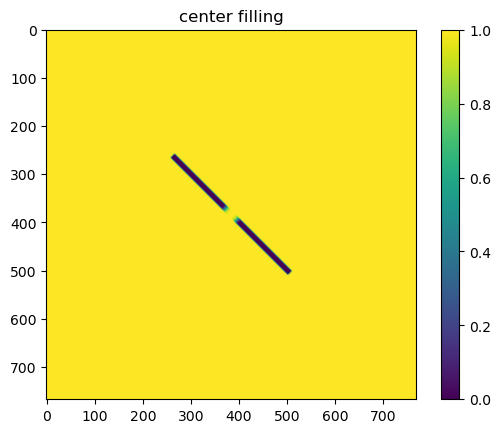

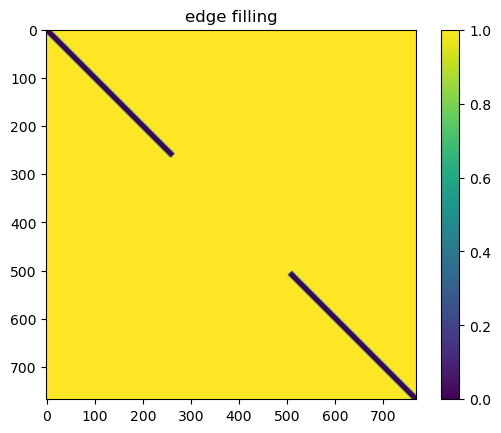

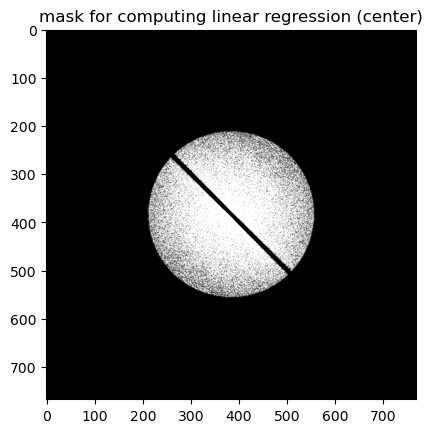

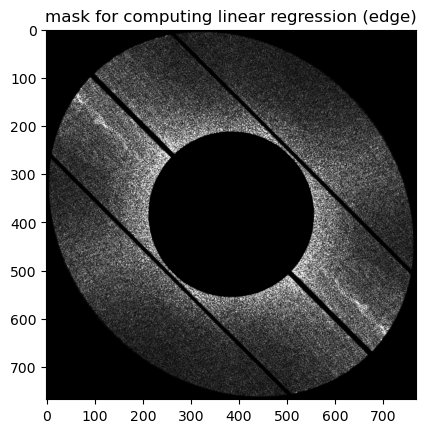

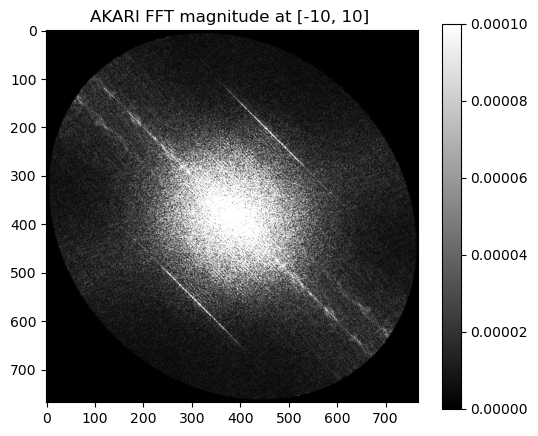

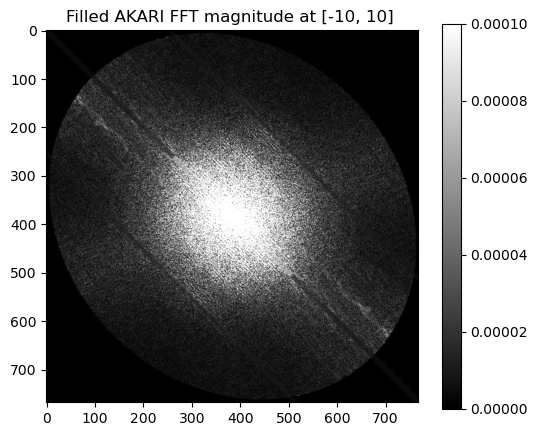

slope (center): 0.6768357965716693
intercept (center): 31.689932334076175
slope (edge): 0.6229353420493414
intercept (edge): 4.678656356124553


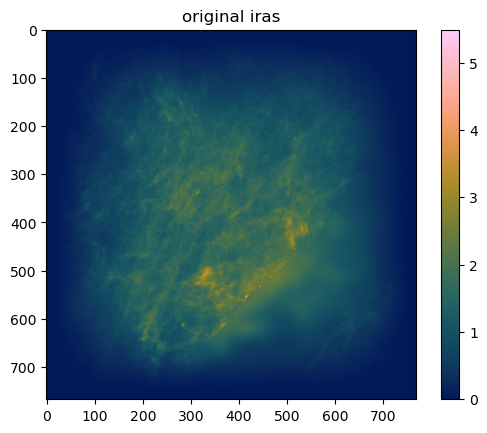

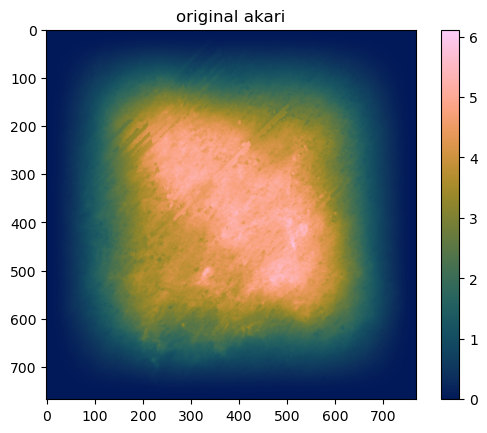

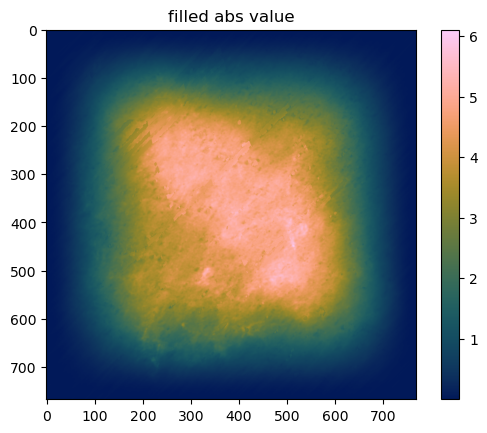

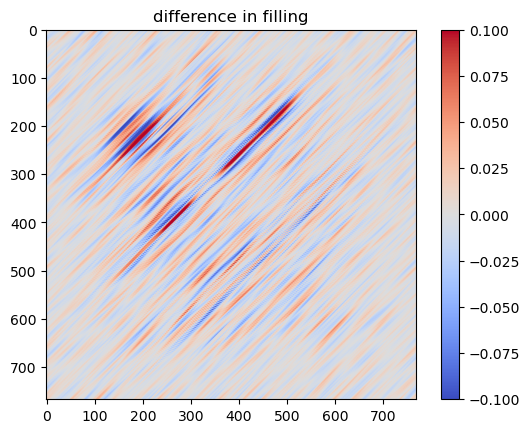

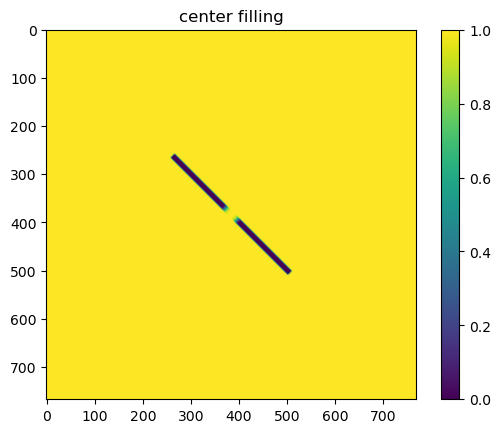

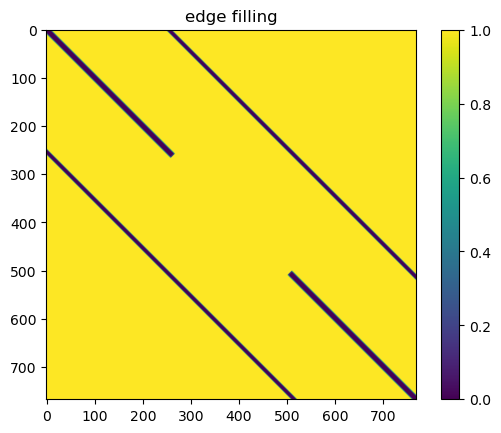

In [12]:
onestripe = fill(stripes=stripes, mask = mask, centerlimit = 0.05, akari_abs_fft= akari_abs_fft, iras_abs_fft= iras_abs_fft, akari_phase= akari_phase)
threestripes = fill(stripes=extrastripes, mask = mask2, centerlimit = 0.05, akari_abs_fft= akari_abs_fft, iras_abs_fft= iras_abs_fft, akari_phase= akari_phase)

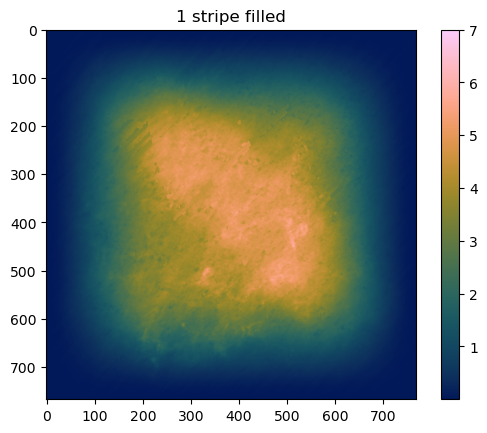

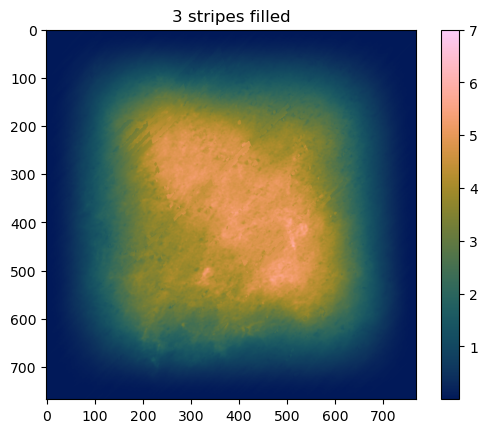

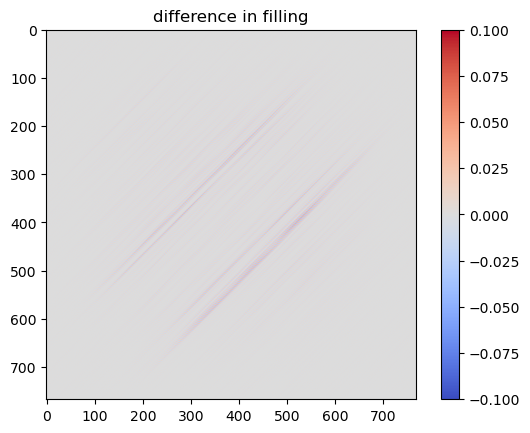

In [13]:
plt.imshow(np.abs(onestripe), cmap = cmc.batlow, vmax=7)
plt.title('1 stripe filled')
plt.colorbar()
plt.show()

plt.imshow(np.abs(threestripes), cmap = cmc.batlow, vmax = 7)
plt.title('3 stripes filled')
plt.colorbar()
plt.show()

plt.imshow(onestripe.real - threestripes.real, vmin = -1e-1, vmax=1e-1, cmap = "coolwarm")
plt.title('difference in filling')
plt.colorbar()
plt.show()

#### Trying a new patch

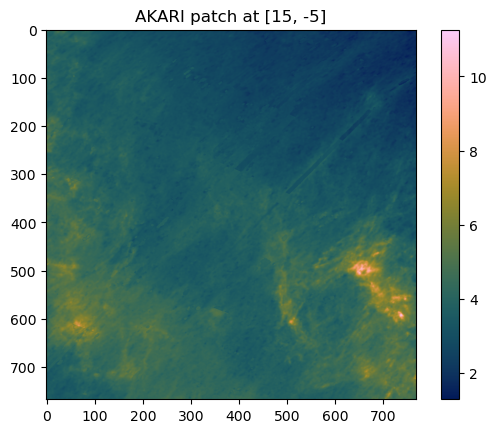

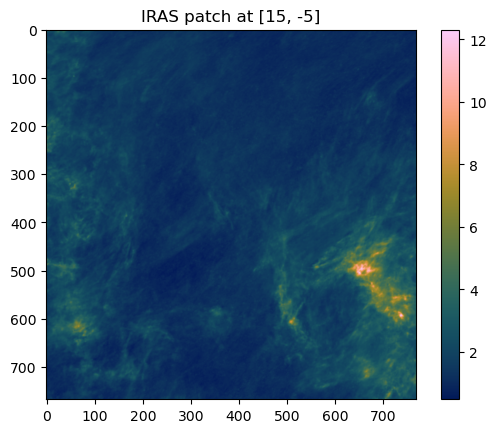

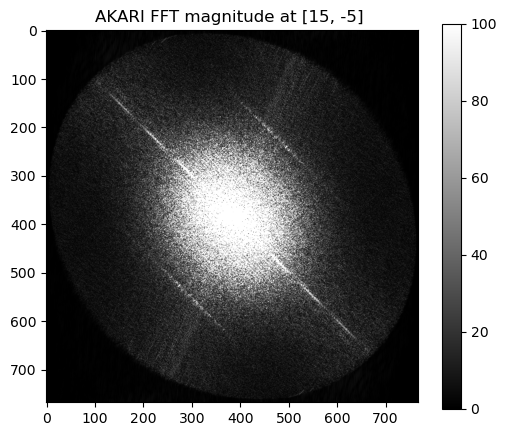

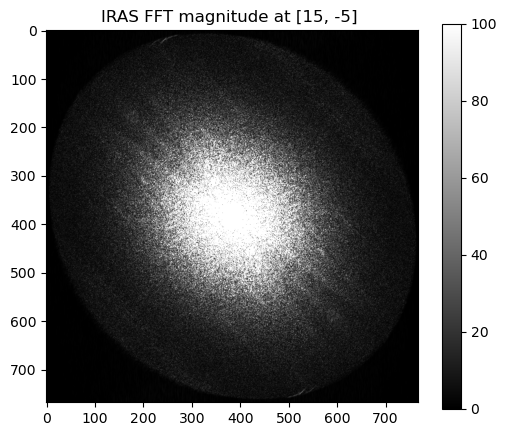

In [14]:
rot = [15, -5]
akari_patch, iras_patch, akari_abs_fft, iras_abs_fft, akari_phase, iras_phase = fft(rot=rot)

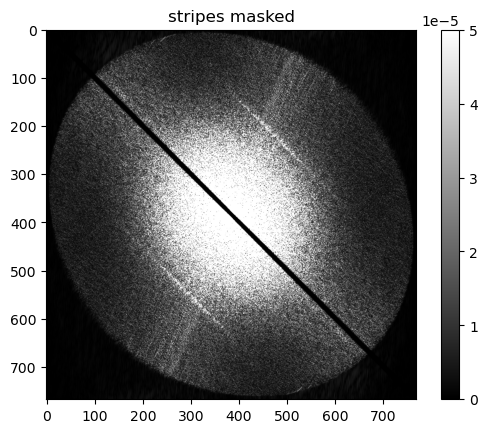

In [15]:
angles = [135]
width = 0.01
core_width = width/2
fade_width = width/2

mask = np.zeros_like(akari_abs_fft)

for angle in angles:
    theta = np.radians(angle)
    # Direction vector
    dx = np.cos(theta)
    dy = np.sin(theta)

    # Distance of each point from the stripe line (through center)
    distance = np.abs(kx * dx + ky * dy)

    # Build apodization mask using cosine taper
    stripe = distance <= (width / 2)
    fade = (distance > (width / 2)) & (distance < (width))
    

    mask[stripe] = 1
    mask[fade] = 0.5 * (1 + np.cos(np.pi * (distance[fade] - core_width) / fade_width))

stripes = akari_abs_fft * (1 - mask)
    
plt.imshow((stripes)*1e-6, cmap='gray', vmax = 0.00005)
plt.title("stripes masked")
plt.colorbar()
plt.show()

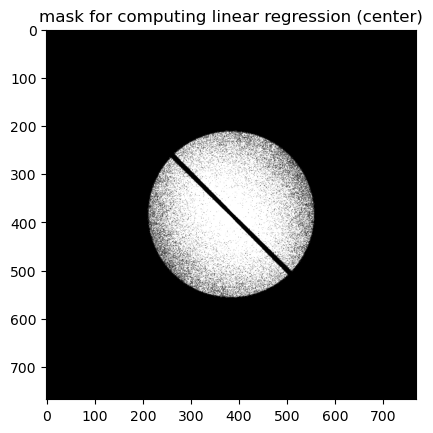

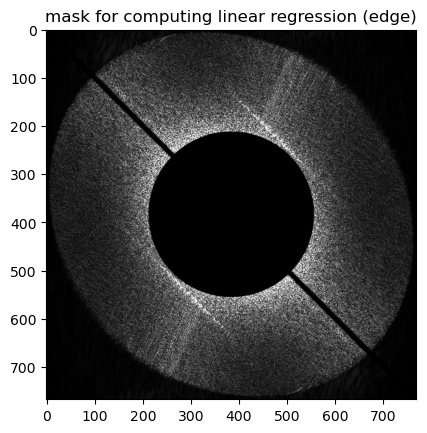

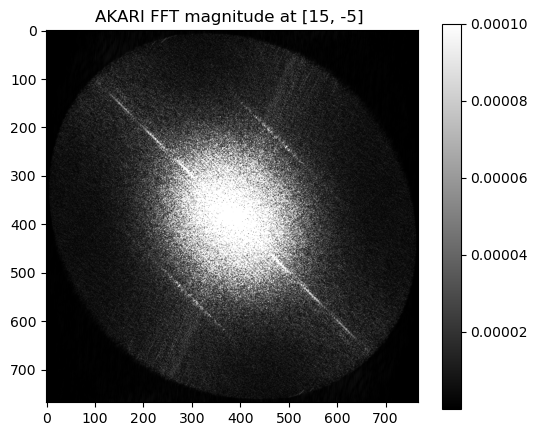

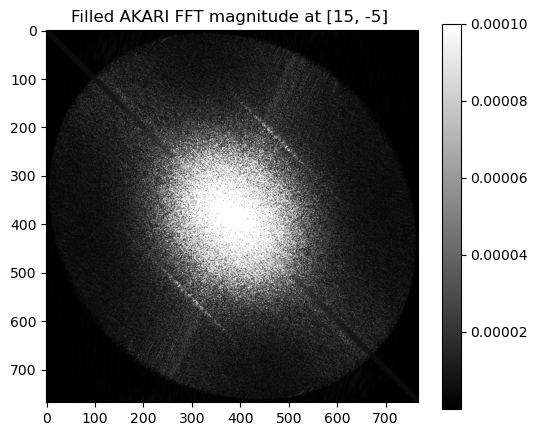

slope (center): 0.655640749652792
intercept (center): 21.32211725048961
slope (edge): 0.5088671852222194
intercept (edge): 4.368816784900951


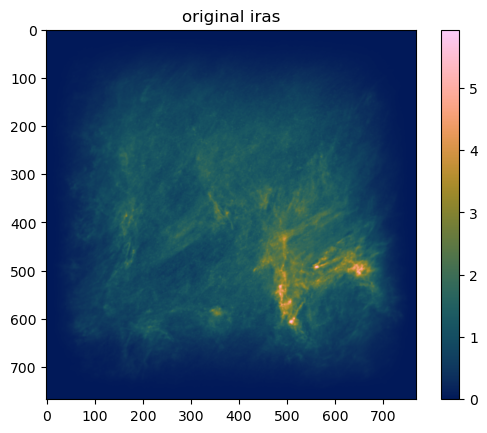

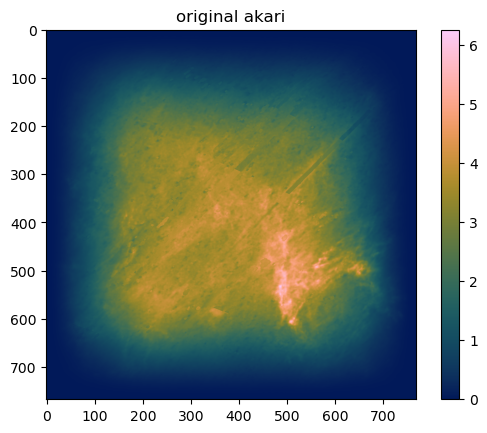

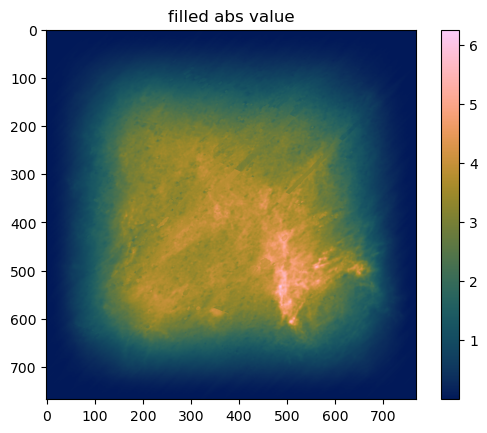

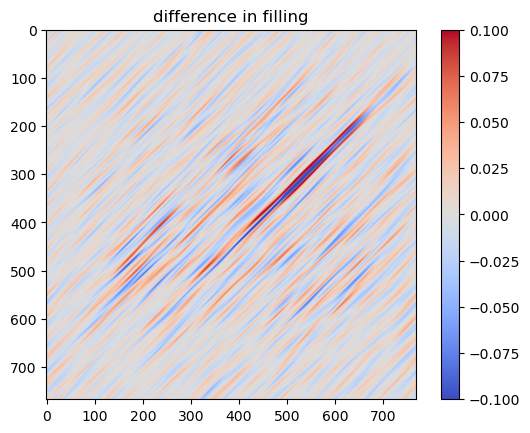

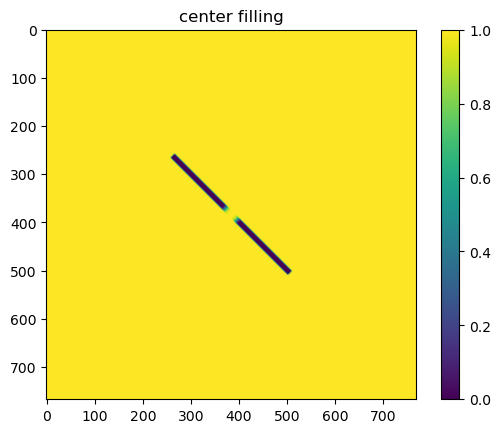

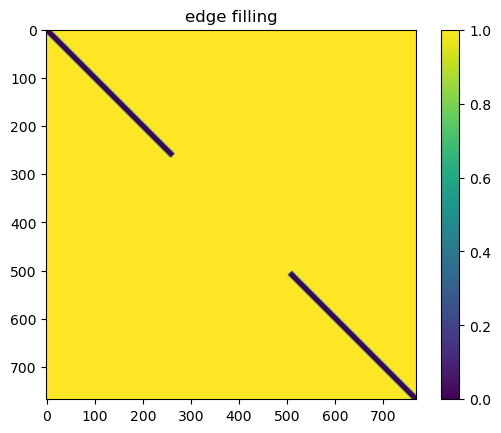

In [16]:
onestripe = fill(stripes=stripes, mask = mask, centerlimit = 0.05, akari_abs_fft= akari_abs_fft, iras_abs_fft= iras_abs_fft, akari_phase= akari_phase)